# Deep Learning: RNN: Disaster Tweets
**Thomas Bohn**   --   **2025-09-20**

{{xxxxx}}  

--  [Main Report](xxxx)  --  [Github Repo](xxxx)  --  [Presentation Slides](xxx)  --  [Presentation Video](xxx) --  

# 1.&nbsp;Introduction

**Problem Statement**

{{xxxxx}}

**Why is it Important?**

{{xxxxx}}

**Limitations of Existing Solutions**

{{xxxxx}}

**Contribution**

{{xxxxx}}

**DataSet**

{{xxxxx}}


## Python Libraries

The following python libraries are used in this notebook.

In [1]:
# File system manangement
import time, datetime, psutil, os
import shutil
import zipfile
from google.colab import userdata
from google.colab import files

# Data manipulation
import numpy as np
import pandas as pd
import math

# Install text storage and manipulation
import re
import json
import pickle
import textwrap

#Install Image processing
from PIL import Image

##################################

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme()

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Model Evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

#################################

# Import Tensor Flow and Keras
import tensorflow as tf
import keras
from keras import layers, models
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, History
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

#################################

# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Global Variables

The following are global variables referenced in this notebook.

In [6]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

In [5]:
# Global Debug flag used to turn on and off more chatty blocks of code
gDEBUG = True
if gDEBUG: print('Debug is set to:', gDEBUG)
# Global Level of Detail of table stats and details
gLOD = 2
print('Level of Detail for functions is set to:', gLOD)

Debug is set to: True
Level of Detail for functions is set to: 2


# 2.&nbsp;Data Source

In this section, the code loads the dataset from Google Drive. A copy of the code from Kaggle was cached on google drive for development in a colab environment.

## Import the Data

In [7]:
# Define the source of the zipped data files
target_file = 'nlp-getting-started.zip'
source_path_root =  '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/data'
destination_path_root = '/content'

# Copy the files to the runtime
shutil.copy(source_path_root+'/'+target_file, destination_path_root+'/')

# Display the files in the destination directory
print(os.listdir(destination_path_root+'/'))

['.config', 'nlp-getting-started.zip', 'test.csv', 'sample_submission.csv', 'drive', 'train.csv', 'sample_data']


In [8]:
# Unzip the files (this is slow)
zip_file_path = destination_path_root+'/'+target_file

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the specified folder
        zip_ref.extractall(destination_path_root)

In [9]:
# Define the file paths in the runtime environment
file_path_root =  '/content'

file_path_train   = file_path_root + '/train.csv'
file_path_test    = file_path_root + '/test.csv'
file_path_sample  = file_path_root + '/sample_submission.csv'

# Load train labels from CSV file
train_labels = pd.read_csv(file_path_train)

# Load test labels from CSV file
test_labels = pd.read_csv(file_path_test)

# Load test labels from CSV file
sample_output = pd.read_csv(file_path_sample)

## Create Label Mappings

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

In [42]:
 # Encoding of labels
label_dict = {'not': 0, 'disaster': 1}
# Create the inverse dictionary
inverted_label_dict = {0: 'not', 1: 'disaster'}
print('label_dict:', label_dict)
print('inverted_label_dict:', inverted_label_dict)

label_dict: {'not': 0, 'disaster': 1}
inverted_label_dict: {0: 'not', 1: 'disaster'}


## Add Basic Columns

In [53]:
train_labels['label']=train_labels['target']
train_labels['length']=train_labels['text'].str.len()
train_labels['word_count']=train_labels['text'].str.split().str.len()

## Preview Data

In [54]:
if gDEBUG:
  # Preview the Data Sources
  print("Sample of Training Labels")
  display(train_labels.head(5))
  print()
  print("Sample of Testing Data")
  display(test_labels.head(5))
  print()
  print("Sample of Results Output:")
  display(sample_output.head(5))

Sample of Training Labels


,id,keyword,location,text,target,length,label,word_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,1,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,1,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,1,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,1,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,1,16



Sample of Testing Data


,id,keyword,location,text,length
0,0,NaN,NaN,Just happened a terrible car crash,34
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,40
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,45



Sample of Results Output:


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [50]:
# Display training labels info
print("Training Labels Info:")
print(train_labels.info())
print()
# Display testing labels info
print("Testing Data Info:")
print(test_labels.info())
print()

Training Labels Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7613 non-null   int64 
 1   keyword     7552 non-null   object
 2   location    5080 non-null   object
 3   text        7613 non-null   object
 4   target      7613 non-null   int64 
 5   length      7613 non-null   int64 
 6   label       7613 non-null   object
 7   word_count  7613 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 475.9+ KB
None

Testing Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
 4   length    3263 non-null   int64 
dtypes: int64(2), objec

In [12]:
 # Preview the Training Label Assignments
print('Label Count of Training Labels')
display(train_labels['target'].value_counts())
print()
print('Imbalance of Labels:', round((train_labels['target'].value_counts()[1]
                                    - train_labels['target'].value_counts()[0]) / len(train_labels), 3))


Label Count of Training Labels


,count
target,
0,4342
1,3271



Imbalance of Labels: -0.141


In [25]:
# Example of the text from the article
example_text = train_labels['text'].iloc[100]
# Print to Screen
print("Length of Text:", len(example_text), "\n")
print(textwrap.fill(example_text, width=100))

Length of Text: 124 

.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion
https://t.co/gFJfgTodad


# 3.&nbsp;Exploratory Data Analysis (EDA)

The EDA phase focuses on understanding the dataset, including data distribution and label counts. Various functions are used to inspect the structure of the dataset, visualize the label distribution, and assess the text length and word count of the documentation. The data is found to be somewhat imbalanced across categories.

## EDA Functions

EDA Functions recycled from previous Natural Language Processing (NLP) analysis projects. The general patter of completing EDA for NLP typically starts with a standard set of tables and charts to understand the data.

*Source:* [auto_classifying_salesforce_cloud_documentation.ipynb](https://github.com/TOM-BOHN/MsDS-supervised-nlp-sfdc-auto-classification/blob/0f26d4b049e22b43e3bffd348e7687b4640c30d2/auto_classifying_salesforce_cloud_documentation.ipynb)

In [45]:
# Function to replace labels in a list based on a label dictionary
def replace_labels(labels, label_dict):
  new_labels = []
  # Iterate through each label in the input list
  for label in labels:
    # If the label exists in the label dictionary, append the replacement label
    if label in label_dict:
      new_labels.append(label_dict[label])
    else:
      new_labels.append(label)

  return new_labels

In [46]:
# Create a dictionary to store the data for each label
def create_data_by_label(data, label_col):
  data_by_label = {}
  # Iterate over the unique labels
  for label in data['label'].unique():
      # Subset the data for the current label
      data_by_label[label] = data[data['label'] == label]

  print("Size of the data by label dictionary:", len(data_by_label), "\n")

  return data_by_label

In [17]:
# Create a function to print key table details
def quick_table_details (df_name, df, level_of_detail = 10):
  # describe the shape and column summary
  if level_of_detail >= 1:
    print('\n####', df_name, '####')
    num_rows = df.shape[0]
    num_cols = df.shape[1]
    print('number of features (columns) = ' + str(num_cols))
    print('number of observations (rows) = ' + str(num_rows))
    print('----------------------------', '\n')
  # print the datatype counts
  if level_of_detail >= 2:
    print('DataType Counts:')
    display(df.dtypes.value_counts())
    print('----------------------------', '\n')
  # print a full list of column names
  if level_of_detail >= 3:
    print('Columns:')
    print(df.columns)
    print('----------------------------', '\n')
  #  expanded table details
  if level_of_detail >= 4:
    print('Description:')
    display(df.describe(include='all'))
    print('----------------------------', '\n')
    print('Info:')
    display(df.info())
    print('----------------------------', '\n')
  #  table records preview
  if level_of_detail >= 5:
    print('Table Preview:')
    x_records = 3
    display(df.head(x_records))
    print('....')
    display(df.tail(x_records))
    print('----------------------------', '\n')

In [18]:
# function to count the number of records in each category and stats
def count_field(df, field = 'label'):
    df_cat_count = pd.DataFrame(df[field].value_counts()).reset_index()
    #df_cat_count = df_cat_count.rename(columns={'label': 'Count', 'index': 'Label'})
    df_cat_count = df_cat_count.sort_values(by = ['count'], ascending = False)
    df_cat_count['Pct of Total'] = round(df_cat_count['count'] / df_cat_count['count'].sum(), 2)
    df_cat_count['Pct of Total Text'] = (df_cat_count['Pct of Total'] * 100).apply(int).apply(str) + ' %'
    return df_cat_count

In [19]:
# define a function to aggregate dataframe on a single category
def shape_df_for_stacked_barchart(df, group_by, stack_by, normalize=True):
    # Check if group_by and stack_by are the same
    if group_by == stack_by:
        # If they are the same, simply return the value counts as a DataFrame
        df_chart = df[group_by].value_counts(normalize=normalize).round(2).to_frame()
        df_chart.index.name = stack_by  # Set the index name for consistency
    else:
        # If they are different, proceed with the original logic
        df_chart = (df
                    .groupby(group_by)[stack_by]
                    .value_counts(normalize=normalize)
                    .round(2)
                    .unstack())
    return df_chart

# defgine a function to plot a bar chart for a single category
def create_single_stacked_bar(df, group_by, stack_by, fig_size = (5,5), normalize=True):
  df_chart = shape_df_for_stacked_barchart(df = df, group_by = group_by, stack_by = stack_by, normalize = normalize)
  if gDEBUG: print(df_chart, '\n')
  fig, ax = plt.subplots(figsize = fig_size)
  # plot the chart
  chart = df_chart.plot.bar(stacked = True,
                    ax = ax,
                    width = 0.3,
                    edgecolor = "black")
  # Customising legend
  ax.legend(fontsize = 10, title_fontsize = 10)

  ax.set_title(group_by, fontsize=10)
  ax.set_xlabel(group_by, fontsize=8)
  ax.set_ylabel('Record Count', fontsize=8)
  return fig


In [20]:
# Visualization of class frequencies
def viz_class_frequency(data_by_label, label_dict):
  values = []
  labels = []
  for i in range(0, len(data_by_label)):
    try:
      values.append(len(data_by_label[i]))
      labels.append(i)
    except:
      pass

  labels = replace_labels(labels, label_dict = inverted_label_dict)

  print(values)
  print(labels)

  # Create the horizontal bar chart
  plt.barh(labels, values)

  # Add labels and title
  plt.xlabel("Record Count")
  plt.ylabel("Labels")
  plt.title("Comparison of Class Frequencies")

  # Display the chart
  plt.show()

In [21]:
# Distribution of number of characters in description
def viz_char_frequency(data_by_label, label_dict):
  values = []
  labels = []
  for i in range(0, len(data_by_label)):
    try:
      values.append(data_by_label[i]['text'].str.len())
      labels.append(i)
    except:
      pass

  labels = replace_labels(labels, label_dict = inverted_label_dict)

  cols = 3
  rows = math.ceil(len(values)/cols)

  fig, axs = plt.subplots(rows, cols, figsize = (10, (rows*3)), sharey = False)

  # Flatten the axs array to iterate over it easily
  axs = axs.flatten()

  for i in range(0, len(data_by_label)):
    sns.histplot(x = values[i], bins = 20, ax = axs[i]).set_title('Class: ' + labels[i], fontsize=10)

  fig.suptitle("Distribution of number of characters in description", y=1.05)

  for i in range(0, len(data_by_label)):
      axs[i].set_xlabel(" ") if i // cols == 0 else axs[i].set_xlabel("Number of characters") # Change: Use cols instead of 2
      if i % cols != 0: axs[i].set_ylabel(" ") # Change: Use cols instead of 2

In [22]:
# Distribution of number of words in description
def viz_word_frequency(data_by_label, label_dict):
  values = []
  labels = []
  for i in range(0, len(data_by_label)):
    try:
      values.append(data_by_label[i]['text'].str.split().map(lambda x: len(x)))
      labels.append(i)
    except:
      pass

  labels = replace_labels(labels, label_dict = inverted_label_dict)

  cols = 3
  rows = math.ceil(len(values)/cols)

  fig, axs = plt.subplots(rows, cols, figsize = (10, (rows*3)), sharey = False)

  # Flatten the axs array to iterate over it easily
  axs = axs.flatten()

  for i in range(0, len(data_by_label)):
    sns.histplot(x = values[i], bins = 20, ax = axs[i]).set_title('Class: ' + labels[i], fontsize=10)

  fig.suptitle("Distribution of number of words in description", y=1.05)

  for i in range(0, len(data_by_label)):
      axs[i].set_xlabel(" ") if i // cols == 0 else axs[i].set_xlabel("Number of words") # Change: Use cols instead of 2
      if i % cols != 0: axs[i].set_ylabel(" ") # Change: Use cols instead of 2

In [23]:
# Distribution of number of words in description
def viz_word_length_frequency(data_by_label, label_dict):
  values = []
  labels = []
  for i in range(0, len(data_by_label)):
    try:
      values.append(data_by_label[i]['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)))
      labels.append(i)
    except:
      pass

  labels = replace_labels(labels, label_dict = inverted_label_dict)

  cols = 3
  rows = math.ceil(len(values)/cols)

  fig, axs = plt.subplots(rows, cols, figsize = (10, (rows*3)), sharey = False)

  # Flatten the axs array to iterate over it easily
  axs = axs.flatten()

  for i in range(0, len(data_by_label)):
    sns.histplot(x = values[i], bins = 20, ax = axs[i]).set_title('Class: ' + labels[i], fontsize=10)

  fig.suptitle("Distribution of average word-length in description", y=1.05)

  for i in range(0, len(data_by_label)):
      axs[i].set_xlabel(" ") if i // cols == 0 else axs[i].set_xlabel("Average word-length")
      if i % cols != 0: axs[i].set_ylabel(" ")

## EDA Analysis: Overview

In [24]:
# Print summary details for the 3 tables in the datasource
quick_table_details (df_name="train_labels", df=train_labels, level_of_detail = 4)


#### train_labels ####
number of features (columns) = 6
number of observations (rows) = 7613
---------------------------- 

DataType Counts:


,count
int64,3
object,3


---------------------------- 

Columns:
Index(['id', 'keyword', 'location', 'text', 'target', 'length'], dtype='object')
---------------------------- 

Description:


,id,keyword,location,text,target,length
count,7613.000000,7552,5080,7613,7613.00000,7613.000000
unique,NaN,221,3341,7503,NaN,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN,NaN
freq,NaN,45,104,10,NaN,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966,101.037436
std,3137.116090,NaN,NaN,NaN,0.49506,33.781325
min,1.000000,NaN,NaN,NaN,0.00000,7.000000
25%,2734.000000,NaN,NaN,NaN,0.00000,78.000000
50%,5408.000000,NaN,NaN,NaN,0.00000,107.000000
75%,8146.000000,NaN,NaN,NaN,1.00000,133.000000


---------------------------- 

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
 5   length    7613 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 357.0+ KB


None

---------------------------- 



In [28]:
# show the content of one Article in the data source
print(textwrap.fill(train_labels['text'][55], width=100))

#Kurds trampling on Turkmen flag later set it ablaze while others vandalized offices of Turkmen
Front in #Diyala http://t.co/4IzFdYC3cg


In [30]:
#print column names for each table
print('columns in df_train:', train_labels.columns)
# calculate the count of records in each category
df_cat_count = count_field(df = train_labels, field = 'target')
display(df_cat_count)

columns in df_train: Index(['id', 'keyword', 'location', 'text', 'target', 'length'], dtype='object')


,target,count,Pct of Total,Pct of Total Text
0,0,4342,0.57,56 %
1,1,3271,0.43,43 %


        count
target       
0        4342
1        3271 

[-] the catgory of 0 makes up 56 % of the data.
[-] the catgory of 1 makes up 43 % of the data.


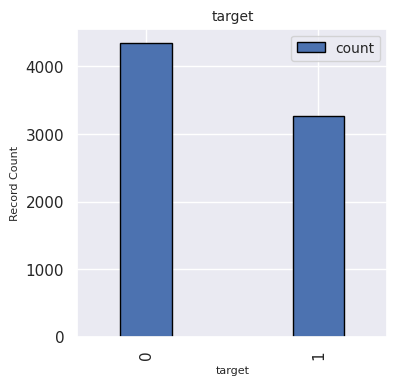

In [31]:
# Summarize the target in the dataset
chart = create_single_stacked_bar(df = train_labels, group_by = 'target', stack_by = 'target', fig_size = (4,4), normalize = False)
table = shape_df_for_stacked_barchart(df = train_labels, group_by = 'target', stack_by = 'target', normalize = False)
# Print a summary of the percent share of the total for each category
for i in range(len(df_cat_count)):
    print('[-] the catgory of', df_cat_count['target'].iloc[i], 'makes up',
           df_cat_count['Pct of Total Text'].iloc[i], 'of the data.')

## EDA Analysis: Text Distribution

Size of the data by label dictionary: 2 

[4342, 3271]
['not', 'disaster']


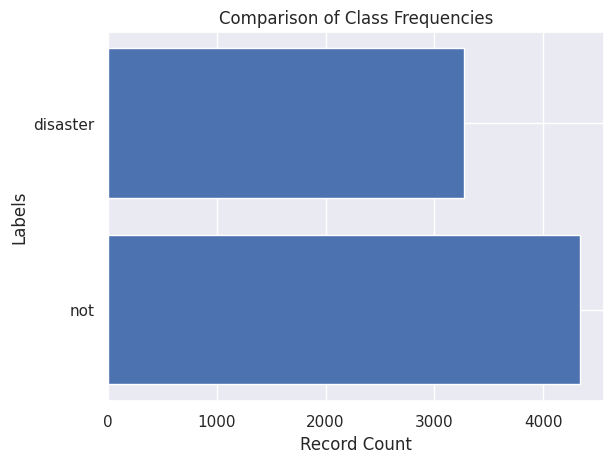

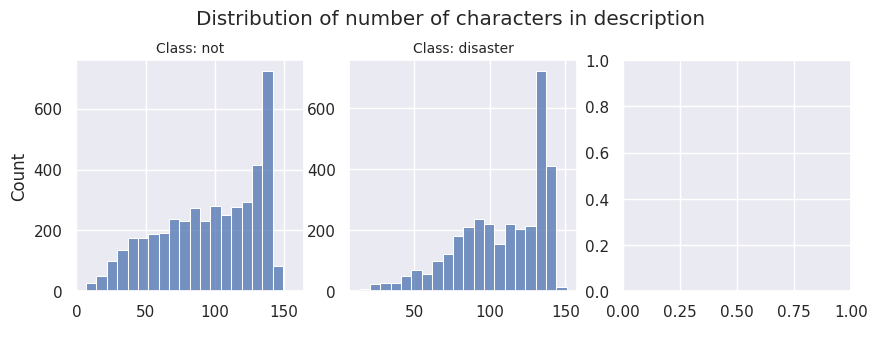

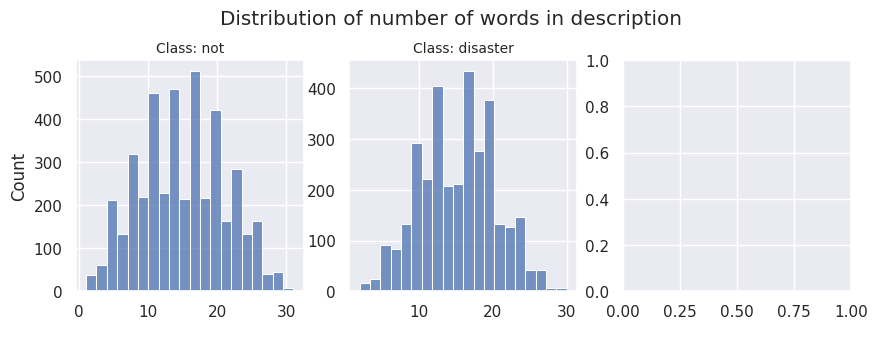

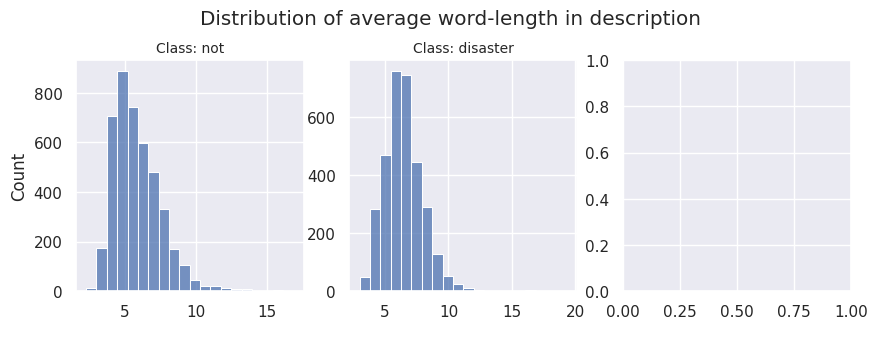

In [55]:
data_by_label = create_data_by_label(data=train_labels, label_col='label')
# Distribution of number of characters in description
viz_class_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of characters in description
viz_char_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of words in description
viz_word_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of words in description
viz_word_length_frequency(data_by_label, label_dict = inverted_label_dict)

## EDA Results

ADD HERE

# 4.&nbsp;Train-Validation-Test Split

Split the dataset into training, validation, and test sets. Use tratified splitting to ensure that the class distribution remains consistent across these sets. The distribution of records across the labels is visualized to ensure a balanced split.

## Test Split Functions

In [ ]:
{{xxxxx}}

## Test Split Analysis

In [ ]:
{{xxxxx}}

# 5.&nbsp;Data Cleansing & Text Normalization

{{xxxxx}}

## Core Normalization Functions

In [ ]:
{{xxxxx}}

## Apply Text Normalization

In [ ]:
{{xxxxx}}

# 6.&nbsp;Feature Engineering with TF-IDF

The TfidfVectorizer from scikit-learn is used to convert the text documents into numerical features. The vectorizer transforms the collection of documents into a matrix of token counts, which is then normalized using the Term Frequency-Inverse Document Frequency (TF-IDF) transformation. This matrix representation of the text data serves as input to the machine learning models.

## TF_IDF Functions

In [ ]:
{{xxxxx}}

## Vectorization

In [ ]:
{{xxxxx}}

# 7.&nbsp; Baseline Models: Supervised

## Model Functions

In [ ]:
{{xxxxx}}

## Build, Train, and Evaluate the Model

In [ ]:
{{xxxxx}}

# 8.&nbsp; Hyperparameter Tuning

## Tuning Functions

In [ ]:
{{xxxxx}}

## Execute Hyperparameter Tuning

In [ ]:
{{xxxxx}}

# 9.&nbsp;Final Prediction and Evaluation

## Evaluation Functions

In [ ]:
{{xxxxx}}

## Train the Final Model

In [ ]:
{{xxxxx}}

## Evaluate the Model

In [ ]:
{{xxxxx}}

## Explore Errors

In [ ]:
{{xxxxx}}

# 10.&nbsp;Scale the Auto-Classifier

## Auto-Classifier Functions

In [ ]:
{{xxxxx}}

## Rerun Process for L1

In [ ]:
{{xxxxx}}

## Rerun Process for L2

In [ ]:
{{xxxxx}}

# 11.&nbsp; Conclusions

{{xxxxx}}

## Results Summary

### Model Result Summary


**Baseline Results**

{{xxxxx}}

**Hyperparameter Tuning Results**

{{xxxxx}}

**Best Model Results**

{{xxxxx}}

**Best Model Performance**

{{xxxxx}}

## Model Comparison

### Model Comparisons and Findings

{{xxxxx}}

#### Baseline Results

{{xxxxx}}

#### Hyperparameter Tuning

{{xxxxx}}

#### Best Model Results

{{xxxxx}}

#### Performance Breakdown (Best Model)

{{xxxxx}}

#### Conclusion

{{xxxxx}}

## Concluding Observations

## Patterns and Conclusions Across the Models

{{xxxxx}}

# 12.&nbsp; References

**Kaggle Competition**

- [1] Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.


**Documentation and References**

- [2] Kaggle. KerasNLP starter notebook Disaster Tweets. 2023. https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets
- [3] Kaggle. NLP Getting Started Tutorial. 2019. https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial
- [4] Kaggle. NLP with RNN for Tweet Analysis (79.9% acc). 2025. https://www.kaggle.com/code/jonchernoch/nlp-with-rnn-for-tweet-analysis-79-9-acc
- [5] Kaggle. Keras LSTM for Sentiment Disaster Analysis. 2020. https://www.kaggle.com/code/guidosalimbeni/keras-lstm-for-sentiment-disaster-analysis
- [6] Kaggle. NLP (Disaster Tweets) with Glove and LSTM. 2020. https://www.kaggle.com/code/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/notebook
- [7] Kaggle. NLP 📝 GloVe, BERT, TF-IDF, LSTM... 📝 Explained. 2021. https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained
